# Probabilistic model for Battery Degradation Prognostics
__TODO:__ Complete model documentation 

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow_probability.python.mcmc import util as mcmc_util
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate synthetic data

In [74]:
# true values of the parameters
b_true = 0.003

t = np.arange(0,60, 3) #cycles
y = np.exp(-b_true*t) + 0.01*np.random.randn(20) # internal battery performance expressed in C/1 capacity

# Priors

In [75]:
rv_b = tfd.Uniform(low = 0.0, high = 0.02, name = 'b')

# Log-prob function

In [76]:
def joint_logprob(cycles, observations, b):
    n_obs = observations.shape[0].value
    y_model = tf.exp(-b*cycles)
    rv_model = tfd.Independent(tfd.Normal(loc = y_model, scale = 0.01),
                                reinterpreted_batch_ndims=1, name = 'model')
    
    sum_log_prob = rv_b.log_prob(b) + rv_model.log_prob(observations)
    return sum_log_prob
    
    

# HMC

In [77]:
samples = 10000
burnin = 2000

initial_state = [0.01]

cycles = tf.convert_to_tensor(t,tf.float32)
observations = tf.convert_to_tensor(y,tf.float32)

unormalized_target_posterior= lambda *args: joint_logprob(cycles, observations, *args)



#----Setting up the mcmc sampler
[b_samples], kernel_results = tfp.mcmc.sample_chain(num_results= samples, num_burnin_steps= burnin,
                                                               current_state=initial_state,
                                                              kernel= tfp.mcmc.HamiltonianMonteCarlo(
                                                                      target_log_prob_fn=unormalized_target_posterior,
                                                                      step_size = 1.059e-4,
                                                                      num_leapfrog_steps=3,
                                                                      ),parallel_iterations=4)



acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.is_accepted))


with tf.Session() as sess:
    tstart = time.time()
    [b_samples_, acceptance_rate_] = sess.run([b_samples, acceptance_rate])
    print(time.time()-tstart)
print('acceptance_rate:', acceptance_rate_)

5.261234760284424
acceptance_rate: 0.8007


Text(0.5,1,'b samples')

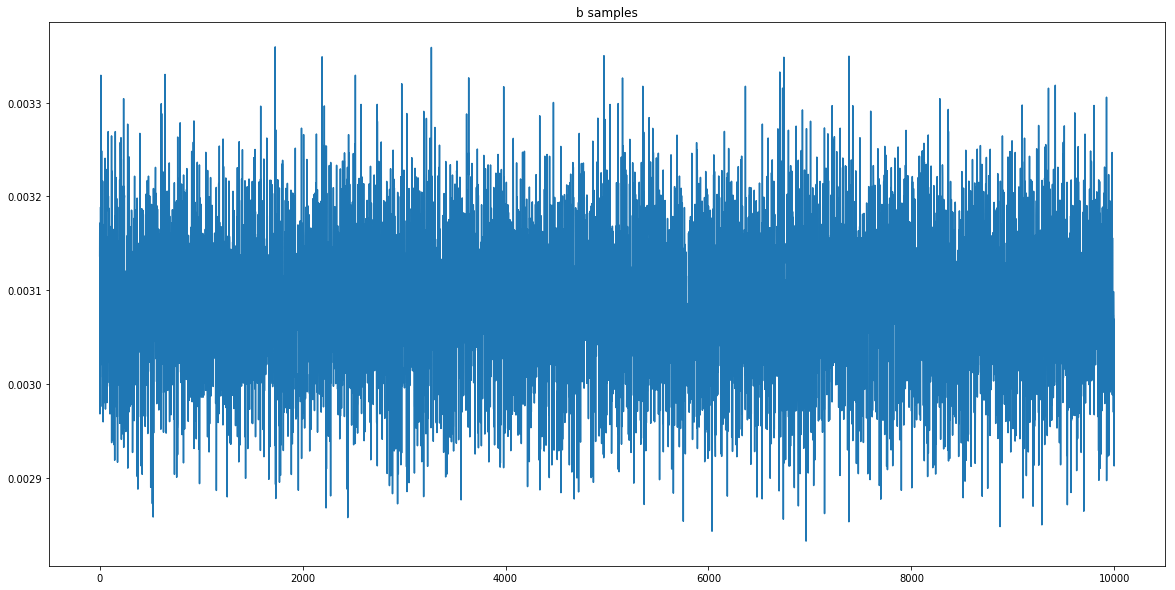

In [78]:
# plotting the mcmc chains
plt.figure(figsize=(20,10))
plt.plot(np.arange(samples), b_samples_)
plt.title('b samples')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49b47a0be0>]],
      dtype=object)

<Figure size 864x864 with 0 Axes>

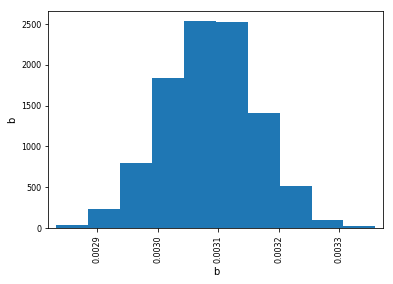

In [79]:
labels = ['b']
#Scatter plot for the parameters
df = pd.DataFrame(b_samples_, columns = labels)
plt.figure(figsize = (12,12))
pd.plotting.scatter_matrix(df)

In [80]:
b_median = np.median(b_samples_)
b_mean = np.mean(b_samples_)
b_std = np.std(b_samples_)
print(b_mean, b_median, b_std)

0.0030858333 0.0030875623 7.6251345e-05


# Inference

In [81]:
def posterior(par_samples, time):
    n_s = len(par_samples)
    n_inputs = len(time)
    y_model = np.exp(-time[:,None]*par_samples[None,:])
    y_model = tf.convert_to_tensor(y_model, tf.float32)
    rv_model = tfd.Normal(loc = y_model, scale = 0.01)
    samples = rv_model.sample(1)
    with tf.Session() as sess:
        samples_ = sess.run(samples)
    
    return samples_
    

In [82]:
time = np.arange(0,200,3)
y_samples = posterior(b_samples_, time)[0]

In [83]:
print(y_samples.shape)

(67, 10000)


In [84]:
lower_per = np.percentile(y_samples,2.5, axis = 1)
upper_per = np.percentile(y_samples,97.5, axis = 1)

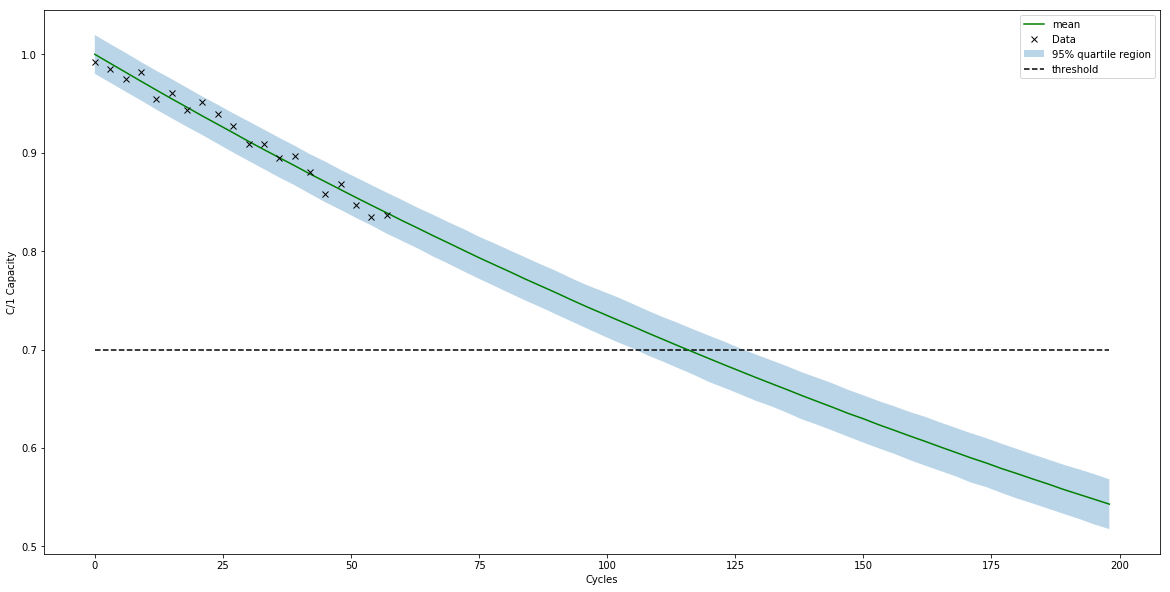

In [85]:
plt.figure(figsize =(20,10))
plt.plot(time, np.mean(y_samples,axis=1), 'g', label = 'mean')
plt.plot(t,y,'kx', label = 'Data')
plt.fill_between(time, lower_per, upper_per, label = '95% quartile region', alpha = 0.3)
plt.xlabel('Cycles')
plt.ylabel('C/1 Capacity')
plt.hlines(0.7, np.min(time), np.max(time), linestyles = '--', label = 'threshold')
plt.legend()
